In [1]:

import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

import torch
import pytorch_lightning as pl

from benchmark.data.datasets import BinaryDetectionDataset
from benchmark.data.data_module import BenchmarkDataModule
from benchmark.models.lit_binary_classifier import LitClassifier

# 1) Annotate your MGF (if you haven’t yet)
ORIG_MGF   = PROJECT_ROOT / "data/massspecgym/MassSpecGym.mgf"
LABELED_MGF= PROJECT_ROOT / "data/massspecgym/MassSpecGym_chlorine.mgf"
label_fn   = lambda md: float("Cl" in md.get("formula",""))
BinaryDetectionDataset.annotate_mgf(
    input_pth = ORIG_MGF,
    output_pth= LABELED_MGF,
    label_fn  = label_fn
)

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


/Users/macbook/CODE/DreaMS_MIMB/data/massspecgym/MassSpecGym_chlorine.mgf already exists; skipping annotation.


In [3]:
# 2) Prepare Dataset & DataModule
from massspecgym.data.transforms import SpecTokenizer
spec_transform = SpecTokenizer(n_peaks=64)

ds = BinaryDetectionDataset(
    pth           = LABELED_MGF,
    spec_transform= spec_transform,
)
dm = BenchmarkDataModule(dataset=ds, batch_size=64, num_workers=0)

In [4]:
import torch
from pytorch_lightning import Trainer

def get_trainer_kwargs():
    """
    Inspect available hardware and return a dict suitable
    for passing into Trainer(..., **kwargs).
    """
    if torch.cuda.is_available():
        # one or more NVIDIA GPUs
        return {
            "accelerator": "gpu",
            "devices": torch.cuda.device_count(),
            "precision": 16,           # use mixed-precision for speed
        }
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        # Apple Silicon GPU via MPS
        return {
            "accelerator": "mps",
            "devices": 1,
            "precision": 16,           # mixed-precision works on MPS
        }
    else:
        # fallback to CPU
        return {
            "accelerator": "cpu",
            "devices": 1,
        }

In [5]:
# 3) Instantiate the LightningModule with Focal Loss
lit = LitClassifier(
    ckpt_path    = str(PROJECT_ROOT/"data/model_checkpoints/ssl_model.ckpt"),
    num_classes  = 2,        # binary
    n_highest_peaks = 64,
    lr            = 1e-5,    # pick a small LR for stability
    dropout       = 0.1,
    train_encoder = True,
    use_focal     = True,    # turn on focal loss
    gamma         = 0.5,     # focusing parameter
    alpha         = 0.8      # positive‐class weight (fraction of positives)
)

In [6]:
from pytorch_lightning.callbacks import Callback
import torch

class MetricsLogger(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses   = []
        self.val_aucs     = []
        self.val_prs      = []
        self.val_f1s      = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        loss = (
            outputs.detach().cpu().item()
            if isinstance(outputs, torch.Tensor)
            else outputs['loss'].detach().cpu().item()
        )
        self.train_losses.append(loss)

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        m = trainer.callback_metrics
        # note: callback_metrics keys are strings exactly as you logged them
        if 'val_loss' in m:
            self.val_losses.append(m['val_loss'].cpu().item())
        if 'val_auc' in m:
            self.val_aucs.append(m['val_auc'].cpu().item())
        if 'val_pr' in m:
            self.val_prs.append(m['val_pr'].cpu().item())
        if 'val_f1' in m:
            self.val_f1s.append(m['val_f1'].cpu().item())

In [7]:
metrics_cb = MetricsLogger()
trainer_kwargs = get_trainer_kwargs()

In [8]:
trainer = pl.Trainer(
    max_epochs=1,
    gradient_clip_val=0.5,
    callbacks=[metrics_cb],
    **get_trainer_kwargs()
)

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logg

In [9]:
# 5) Fit & test
trainer.fit(lit, dm)

Loading `train_dataloader` to estimate number of stepping batches.
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | DreamsClassifier       | 95.6 M
1 | criterion | FocalLoss              | 0     
2 | train_acc | BinaryAccuracy         | 0     
3 | val_acc   | BinaryAccuracy         | 0     
4 | val_auc   | BinaryAUROC            | 0     
5 | val_pr    | BinaryAveragePrecision | 0     
6 | val_f1    | BinaryF1Score          | 0     
-----------------------------------------------------
95.6 M    Trainable params
0         Non-trainable params
95.6 M    Total params
382.202   Total estim

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true po

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 37. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=1` reached.


In [13]:
metrics_cb

In [11]:
trainer.test(lit, dm)

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9070403575897217
         val_auc            0.48092570900917053
         val_f1             0.2805721163749695
        val_loss            0.13999168574810028
         val_pr             0.37273091077804565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.13999168574810028,
  'val_acc': 0.9070403575897217,
  'val_auc': 0.48092570900917053,
  'val_pr': 0.37273091077804565,
  'val_f1': 0.2805721163749695}]

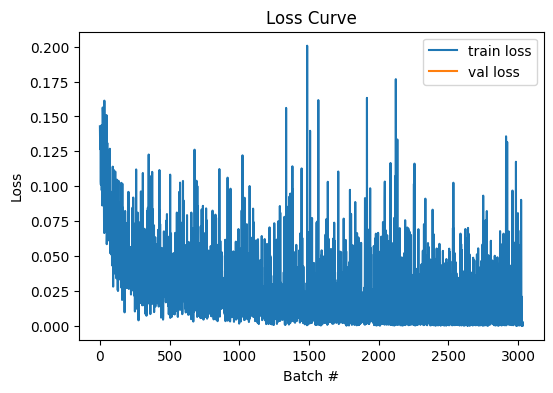

In [15]:
import matplotlib.pyplot as plt

# 1) Loss
plt.figure(figsize=(6,4))
plt.plot(metrics_cb.train_losses, label="train loss")
plt.plot(metrics_cb.val_losses,   label="val loss")
plt.xlabel("Batch #"); plt.ylabel("Loss")
plt.legend(); plt.title("Loss Curve")
plt.show()

# 2) AUC
if metrics_cb.val_aucs:
    plt.figure(figsize=(6,4))
    plt.plot(metrics_cb.val_aucs, label="val AUROC", color='tab:green')
    plt.xlabel("Batch #"); plt.ylabel("AUROC")
    plt.legend(); plt.title("Validation AUROC")
    plt.show()

# 3) Average Precision
if metrics_cb.val_prs:
    plt.figure(figsize=(6,4))
    plt.plot(metrics_cb.val_prs, label="val AP", color='tab:purple')
    plt.xlabel("Batch #"); plt.ylabel("Average Precision")
    plt.legend(); plt.title("Validation Precision-Recall AUC")
    plt.show()

# 4) F1 Score
if metrics_cb.val_f1s:
    plt.figure(figsize=(6,4))
    plt.plot(metrics_cb.val_f1s, label="val F1", color='tab:orange')
    plt.xlabel("Batch #"); plt.ylabel("F1 Score")
    plt.legend(); plt.title("Validation F1 Over Time")
    plt.show()